In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, auc,roc_curve

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("train_ZoGVYWq.csv")
test = pd.read_csv("test_66516Ee.csv")

In [3]:
train.head()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
0,110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1
1,41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,1
2,31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0
3,19415,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1
4,99379,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1


In [4]:
test.head()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium
0,649,0.001,27384,51150,0.0,0.0,0.0,99.89,7,A,Rural,3300
1,81136,0.124,23735,285140,0.0,0.0,0.0,98.93,19,A,Urban,11700
2,70762,1.000,17170,186030,0.0,0.0,0.0,NaN,2,B,Urban,11700
3,53935,0.198,16068,123540,0.0,0.0,0.0,99.00,11,B,Rural,5400
4,15476,0.041,10591,200020,1.0,0.0,0.0,99.17,14,A,Rural,9600


In [8]:
train['sourcing_channel'].value_counts()

A    43134
B    16512
C    12039
D     7559
E      609
Name: sourcing_channel, dtype: int64

In [13]:
train.columns

Index(['id', 'perc_premium_paid_by_cash_credit', 'age_in_days', 'Income',
       'Count_3-6_months_late', 'Count_6-12_months_late',
       'Count_more_than_12_months_late', 'application_underwriting_score',
       'no_of_premiums_paid', 'sourcing_channel', 'residence_area_type',
       'premium', 'renewal'],
      dtype='object')

In [11]:
train_test = train.append(test)

In [15]:
train_test_use = pd.concat([train_test[['id', 'perc_premium_paid_by_cash_credit', 'age_in_days', 'Income','Count_3-6_months_late', 'Count_6-12_months_late', 'Count_more_than_12_months_late', 'application_underwriting_score', 'no_of_premiums_paid', 'premium', 'renewal']], pd.get_dummies(train_test[['sourcing_channel', 'residence_area_type']])], axis=1)
train_test_use.head()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,renewal,sourcing_channel_A,sourcing_channel_B,sourcing_channel_C,sourcing_channel_D,sourcing_channel_E,residence_area_type_Rural,residence_area_type_Urban
0,110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,3300,1.0,0,0,1,0,0,0,1
1,41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,18000,1.0,1,0,0,0,0,0,1
2,31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,3300,0.0,0,0,1,0,0,1,0
3,19415,0.049,15341,250510,0.0,0.0,0.0,99.57,9,9600,1.0,1,0,0,0,0,0,1
4,99379,0.052,31400,198680,0.0,0.0,0.0,99.87,12,9600,1.0,0,1,0,0,0,0,1


In [16]:
X_train_all=train_test_use[0:len(train.index)]
X_test=train_test_use[len(train.index):len(train_test_use.index)]

X_train_all.columns = [str(i) for i in X_train_all.columns]
X_test.columns = [str(i) for i in X_test.columns]
features=list(X_train_all.columns)
features.remove('renewal')
features.remove('id')
X_train=X_train_all.sample(frac=0.80, replace=False)
X_valid=pd.concat([X_train_all, X_train]).drop_duplicates(keep=False)

dtrain = xgb.DMatrix(X_train[features],X_train['renewal'] , missing=np.nan)
dvalid = xgb.DMatrix(X_valid[features],missing=np.nan)
dtest = xgb.DMatrix(X_test[features], missing=np.nan)

In [55]:
nrounds = 200
watchlist = [(dtrain, 'train')]
params = {"objective": "binary:logistic","booster": "gbtree", "nthread": 4, "silent": 1,
                "eta": 0.087, "gamma":0.008, "max_depth": 6, "max_delta_step":0, "subsample": 0.9, "colsample_bytree": 0.7,
                "min_child_weight": 1, "sketch_eps":.02, "seed": 2016, "tree_method": "exact", "normalize_type":"tree", "eval_metric":"auc"}
bst = xgb.train(params, dtrain, num_boost_round=nrounds, evals=watchlist, verbose_eval=200)

[0]	train-auc:0.766996
[199]	train-auc:0.91001


In [56]:
valid_preds = bst.predict(dvalid)
test_preds = bst.predict(dtest)
roc_auc_score(X_valid['renewal'], valid_preds)

0.8329734112074528

In [25]:
np.log(2.73)

1.0043016091968684

In [33]:
def effort_calc(prediction):
    return np.log(((20 * prediction)/(21*prediction - 1))**5)

In [39]:
effort_calc(.8)

0.06289391103429989

In [35]:
def incentive_calc(effort):
    return np.log((10/(10 - effort))**400)

In [57]:
effort_test = [effort_calc(i) for i in list(test_preds)]
incentive_test = [incentive_calc(i) for i in list(effort_test)]

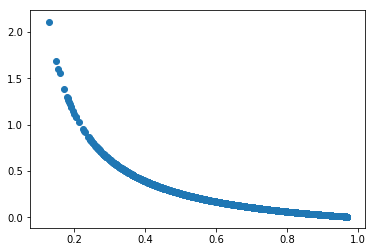

In [46]:
plt.scatter(list(test_preds),effort_test)

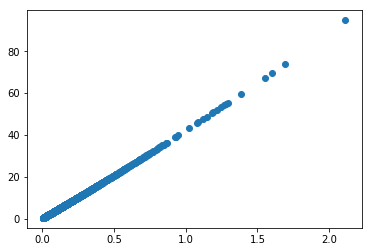

In [47]:
plt.scatter(effort_test,incentive_test)

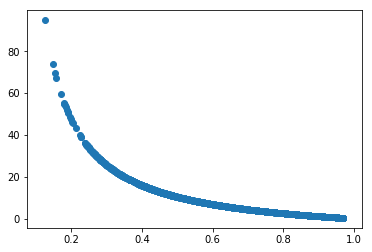

In [48]:
plt.scatter(list(test_preds),incentive_test)

In [58]:
incentive_test_new = [i*1000 for i in incentive_test]
incentive_test_new[:10]

[148.4014318481952,
 258.8793218741517,
 2531.8057204797983,
 244.0527467274087,
 647.3246605866464,
 91.6877420419105,
 2574.053182277999,
 2870.118580117135,
 35.80349977937852,
 29.786803059224606]

In [59]:
sub = pd.DataFrame({'id':test['id'],'renewal':test_preds,'incentives':incentive_test_new})
sub[['id','renewal','incentives']].to_csv('sub_'+str(i)+'.csv', index = False)
i = i+1